This training run is done on the new dataset with 1830 airfoils, 1 mach #, 25 AoA #s, and 3 Re #s.

It runs on the redefined NIF model.

In [19]:
%load_ext autoreload
%autoreload 2

# Define autroreload so that it doesn't cause pain in the ass when we change the functions and run this notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# Import all the models, training functions, manipulators here

# Define the relative paths, append it to the system path
import sys
from pathlib import Path
project_root = Path.cwd().resolve().parents[4]
github_root = Path.cwd().resolve().parents[3]
sys.path.append(str(project_root))
sys.path.append(str(github_root))

print(project_root)
print(github_root)

# Import shenanigans
from defs.helper_functions.training_functions import *
from defs.helper_functions.data_loaders import *
from defs.models.MLP import *

# Time, to precisely: time
import time

C:\SenkDosya\Projects\AeroML
C:\SenkDosya\Projects\AeroML\initial-project


In [21]:
# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")  # Force CPU for testing purposes
print(f"Using device: {device}")

Using device: cuda


In [22]:
# Figure out the data
df = pd.read_csv(rf"C:\SenkDosya\Projects\AeroML\airfoil_data\airfoil_dataset_8bern.csv")

df = df.drop(['N1', 'N2'], axis=1) # Remove N1 and N2 since all the airfoils are subsonic

geom, cond, perf, names= get_dataset(df, loc_geometry=[1,20], loc_cond=[21,23], loc_perf_coeffs=[24,26], loc_names=0) # Get the necessary stuff for the dataset
print(df.shape); print(geom.shape); print(cond.shape); print(perf.shape); print(len(names))

ds = AirfoilDataset(geom, cond, perf, names)

del df, geom, cond, perf, names # Delete these to preserve memory

cfg_loader = {
    'n_epoch': 100,
    'n_train': 1000,
    'n_test': 17250,
    'train_batch': 1
}

dl_train, dl_val, dl_test = get_dataloaders(ds=ds, cfg_loader=cfg_loader)


(137250, 27)
torch.Size([137250, 20])
torch.Size([137250, 3])
torch.Size([137250, 3])
137250


In [23]:
import torch.nn as nn

# Define the model and optimizer

cfg_mlp = {
    'input_dim': 23,
    'output_dim': 3,
    'hidden_units': [2048,2048,2048,2048,2048],
    'shape_activation': nn.Tanh
}


model = MLP(cfg_mlp=cfg_mlp)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

model = model.to(device)

# Define the loss_fn

loss_fn = nn.MSELoss()

In [24]:
# Show the model

from torchviz import make_dot

# Create and move inputs to device
show_tensor_1 = torch.randn(5, 20).to(device)
show_tensor_2 = torch.randn(5, 3).to(device)

# Forward pass
output = model(show_tensor_1, show_tensor_2)

make_dot(output, params=dict(model.named_parameters())).render("model_graph_mlp", format="png")

'model_graph_mlp.png'

In [25]:
# Train the model

# Define the configs of train
cfg_train = {
    'cfg_loader': cfg_loader,
    'dtype': torch.float32,
    'device': device
}

dataloaders = [dl_train, dl_val, dl_test]


collector_dict, model = train(cfg_train=cfg_train, model=model, optimizer=optimizer, loss_fn=loss_fn, dataloaders=dataloaders)

Epoch 1 | Train run 1 loss: 1.8242676258087158
Epoch 1 | Train run 2 loss: 1.9490031003952026
Epoch 1 | Train run 3 loss: 25.688337326049805
Epoch 1 | Train run 4 loss: 100.76548767089844
Epoch 1 | Train run 5 loss: 61.33127975463867
Epoch 1 | Train run 6 loss: 21.004331588745117
Epoch 1 | Train run 7 loss: 8.985994338989258
Epoch 1 | Train run 8 loss: 0.5865398645401001
Epoch 1 | Train run 9 loss: 0.2643090486526489
Epoch 1 | Train run 10 loss: 0.14016816020011902
Epoch 1 | Train run 11 loss: 0.45962971448898315
Epoch 1 | Train run 12 loss: 0.278225302696228
Epoch 1 | Train run 13 loss: 1.4242613315582275
Epoch 1 | Train run 14 loss: 3.291841983795166
Epoch 1 | Train run 15 loss: 0.9765352606773376
Epoch 1 | Train run 16 loss: 3.0366179943084717
Epoch 1 | Train run 17 loss: 1.2145673036575317
Epoch 1 | Train run 18 loss: 2.0182721614837646
Epoch 1 | Train run 19 loss: 2.3716020584106445
Epoch 1 | Train run 20 loss: 0.8458969593048096
Epoch 1 | Train run 21 loss: 0.8602020144462585
Epo

torch.Size([100000])
100000


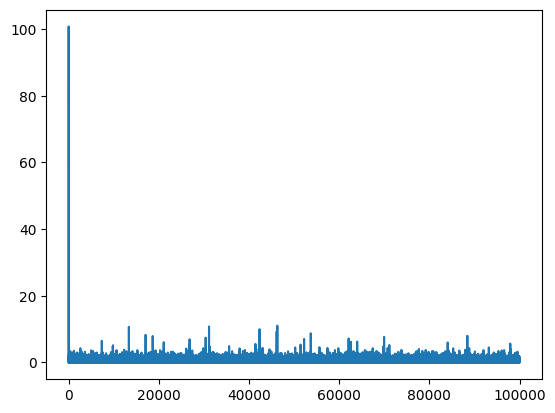

In [26]:
print(collector_dict['losses']['train'].shape)
import numpy as np


train_losses = collector_dict['losses']['train'].numpy()
index= np.arange(100000)

print(train_losses.size)

import matplotlib.pyplot as plt

plt.plot(index, train_losses, )
plt.show()

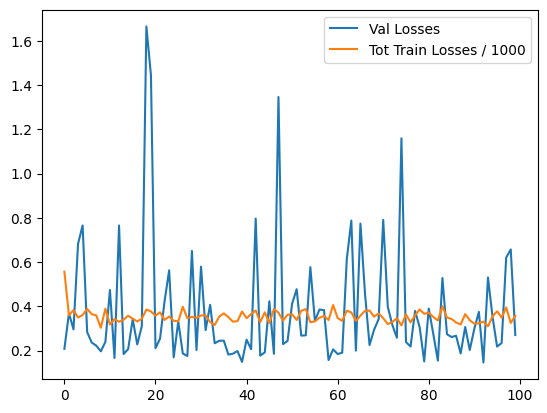

In [27]:
tot_train_losses = collector_dict['losses']['total_train'].numpy()/1000
val_losses = collector_dict['losses']['val'].numpy()

index = np.arange(100)

plt.plot(index, val_losses, label='Val Losses')
plt.plot(index, tot_train_losses, label= 'Tot Train Losses / 1000')
plt.legend()
plt.show()


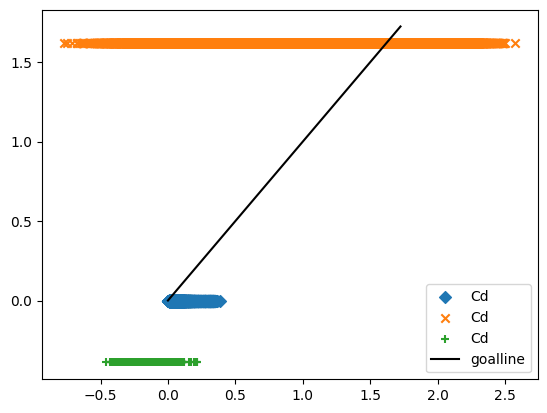

In [28]:
plt.scatter(collector_dict['actual']['test'][:,0].cpu().numpy(), collector_dict['preds']['test'][:,0].cpu().numpy(), marker='D', label= 'Cd')
plt.scatter(collector_dict['actual']['test'][:,1].cpu().numpy(), collector_dict['preds']['test'][:,1].cpu().numpy(), marker='x', label= 'Cd')
plt.scatter(collector_dict['actual']['test'][:,2].cpu().numpy(), collector_dict['preds']['test'][:,2].cpu().numpy(), marker='+', label= 'Cd')
plt.plot(np.arange(17250)/10000, np.arange(17250)/10000, color='k', label='goalline')
plt.legend()
plt.show()
